In [1]:
%store -r X_final

In [2]:
%store -r y_classification

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model, metrics, svm, neighbors

In [4]:
#preimenujmo podatke u X i y
X = X_final
y = y_classification

# Podela skupa podataka 

In [5]:
# stratifikujemo po y da bismo imali u oba skupa jednak odnos instanci obe klase
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

In [6]:
print('U skupu za treniranje i validaciju imamo ', X_train_and_validation.shape[0], 'instanci.')
print('U skupu za testiranje imamo ', X_test.shape[0], 'instanci.')

U skupu za treniranje i validaciju imamo  4560 instanci.
U skupu za testiranje imamo  1140 instanci.


In [7]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(
        X_train_and_validation, y_train_and_validation, test_size = 0.2, stratify=y_train_and_validation, random_state = 5)

# Logisticka regresija

In [8]:
logistic_regression = linear_model.LogisticRegression()

In [9]:
logistic_regression.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
# ciljna funkcija logisticke regresije je zadata sigmoidnom funkcijom
# ako je vrednost ciljne funkcije veca od praga (podrazumevan prag je 0.5), predvidja se pozitivna klasa, a ako je manja od
# praga, predvidja se negativna klasa

In [11]:
# prag moze biti izmedju 0 i 1
# variranjem praga mozemo da kontrolisemo relativne performanse u tacnosti, senzitivnosti i specificnosti
# zato cemo varirati prag

In [12]:
# za metriku cemo racunati tacnost, senzitivnost (pravih pozitivnih instanci) i specificnost (udeo pravih negativnih 
# instanci)
# accuracy = (TP+TN)/(TP+TN+FP+FN)
# sensitivity = TP/(TP+FN)
# specificity = TN/(TN+FP) 

In [13]:
# razlicite vrednosti praga
# ako je vrednost ciljne funkcije manja od praga, predvidja se negativna klasa
# ako je veca, predvidja se pozitivna klasa
pragovi = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [14]:
#  funkcije predict_proba daje ocene verovatnoća pripadnosti pozitivnoj tj. negativnoj klasi, za svaku instancu posebno
logistic_regression.predict_proba(X_val)

array([[0.41917877, 0.58082123],
       [0.13818087, 0.86181913],
       [0.04273741, 0.95726259],
       ...,
       [0.49417318, 0.50582682],
       [0.99392735, 0.00607265],
       [0.80076906, 0.19923094]])

In [15]:
logistic_regression.classes_

array([0, 1])

In [16]:
# vidimo da je levo negativna klasa, a desno pozitivna
# zato nam je izlaz funkcije predict_proba matrica cija je prva kolona verovatnoca da instance pripadaju negativnoj klasi,
# a druga kolona verovatnoca da pripadaju pozitivnoj klasi

In [17]:
# sada cemo za razlicite vrednosti praga racunati gore pomenute metrike
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (logistic_regression.predict_proba(X_val)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_val, y_predicted).ravel()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores.append(specificity)

In [18]:
# matrica konfuzije na skupu za validaciju
metrics.confusion_matrix(y_val, logistic_regression.predict(X_val))

array([[424, 103],
       [121, 264]], dtype=int64)

In [19]:
logistic_regression_auc = metrics.auc(sensitivity_scores,specificity_scores)

In [20]:
print('AUC za obican model logisticke regresije: %.3f' %logistic_regression_auc) 

AUC za obican model logisticke regresije: 0.811


In [21]:
# tacnost, senzitivnost i specificnost racunamo za prag 0.5 koji je po defaultu

In [22]:
print('Tacnost za obican model logisticke regresije: %.3f' %accuracy_scores[5])  

Tacnost za obican model logisticke regresije: 0.754


In [23]:
print('Senzitivnost za obican model logisticke regresije: %.3f' %sensitivity_scores[5]) 

Senzitivnost za obican model logisticke regresije: 0.686


In [24]:
print('Specificnost za obican model logisticke regresije: %.3f' %specificity_scores[5]) 

Specificnost za obican model logisticke regresije: 0.805


# Logisticka regresija sa l2 regularizacijom (ridge)

In [25]:
alphas = np.array([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])

In [26]:
# kada radimo l2 regulazizaciju, postavljamo argumente penalty='l2' i C=1/alpha

In [27]:
Cs = 1/alphas

In [28]:
# sada unakrsnom validacijom biramo optimalni parametar 
optimal_score = 0
optimal_C = 0
validation_scores = []

for C in Cs:
    model = linear_model.LogisticRegression(penalty='l2', C=C)
    scores = model_selection.cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
    score = scores.mean()
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_C = C

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [29]:
optimal_score

0.7881017612524461

In [30]:
optimal_C

0.1

In [31]:
# sada sa optimalnim parametrom pravimo konacan model

In [32]:
logistic_regression_l2 = linear_model.LogisticRegression(penalty='l2', C=optimal_C)

In [33]:
logistic_regression_l2.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [34]:
pragovi

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [35]:
accuracy_scores_l2 = []
sensitivity_scores_l2 = []
specificity_scores_l2 = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (logistic_regression_l2.predict_proba(X_val)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_val, y_predicted).ravel()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores_l2.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores_l2.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores_l2.append(specificity)

In [36]:
logistic_regression_l2_auc = metrics.auc(sensitivity_scores_l2,specificity_scores_l2)

In [37]:
print('AUC za model logisticke regresije sa l2 regularizacijom: %.3f' %logistic_regression_l2_auc) 

AUC za model logisticke regresije sa l2 regularizacijom: 0.817


In [38]:
print('Tacnost za model logisticke regresije sa l2 regularizacijom: %.3f' %accuracy_scores_l2[5])

Tacnost za model logisticke regresije sa l2 regularizacijom: 0.751


In [39]:
print('Senzitivnost za model logisticke regresije sa l2 regularizacijom: %.3f' %sensitivity_scores_l2[5])

Senzitivnost za model logisticke regresije sa l2 regularizacijom: 0.670


In [40]:
print('Specificnost za model logisticke regresije sa l2 regularizacijom: %.3f' %specificity_scores_l2[5])

Specificnost za model logisticke regresije sa l2 regularizacijom: 0.810


# Logisticka regresija sa l1 regularizacijom (lasso)

In [41]:
alphas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [42]:
Cs = 1/alphas
Cs

array([1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [43]:
# sada unakrsnom validacijom biramo optimalni parametar 
optimal_score = 0
optimal_C = 0
validation_scores = []

for C in Cs:
    model = linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C)
    scores = model_selection.cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
    score = scores.mean()
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_C = C

In [44]:
optimal_score

0.7900210748155954

In [45]:
optimal_C

1.0

In [46]:
logistic_regression_l1 = linear_model.LogisticRegression(penalty='l1', solver='saga', C=optimal_C)

In [47]:
logistic_regression_l1.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(penalty='l1', solver='saga')

In [48]:
pragovi

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [49]:
accuracy_scores_l1 = []
sensitivity_scores_l1 = []
specificity_scores_l1 = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (logistic_regression_l1.predict_proba(X_val)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_val, y_predicted).ravel()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores_l1.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores_l1.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores_l1.append(specificity)

In [50]:
logistic_regression_l1_auc = metrics.auc(sensitivity_scores_l1,specificity_scores_l1)

In [51]:
print('AUC za model logisticke regresije sa l1 regularizacijom: %.3f' %logistic_regression_l1_auc) 

AUC za model logisticke regresije sa l1 regularizacijom: 0.814


In [52]:
print('Tacnost za model logisticke regresije sa l1 regularizacijom: %.3f' %accuracy_scores_l1[5])

Tacnost za model logisticke regresije sa l1 regularizacijom: 0.755


In [53]:
print('Senzitivnost za model logisticke regresije sa l1 regularizacijom: %.3f' %sensitivity_scores_l1[5])

Senzitivnost za model logisticke regresije sa l1 regularizacijom: 0.678


In [54]:
print('Specificnost za model logisticke regresije sa l1 regularizacijom: %.3f' %specificity_scores_l1[5])

Specificnost za model logisticke regresije sa l1 regularizacijom: 0.812


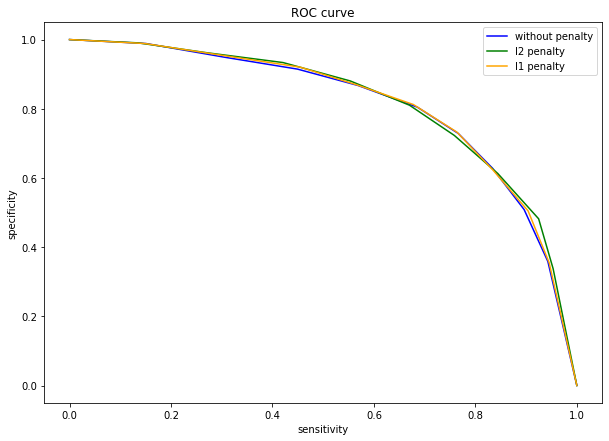

In [55]:
plt.figure(figsize=[10,7])
plt.plot(sensitivity_scores, specificity_scores, color='blue', label='without penalty')
plt.plot(sensitivity_scores_l2, specificity_scores_l2, color='green', label='l2 penalty')
plt.plot(sensitivity_scores_l1, specificity_scores_l1, color='orange', label='l1 penalty')
plt.title('ROC curve')
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.legend(loc='best')
plt.show()

In [56]:
# poredjenje

In [57]:
logistic_regression_auc, logistic_regression_l2_auc, logistic_regression_l1_auc

(0.8114813080657484, 0.8166687202740334, 0.8144311096872766)